In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# hyperparameters
step_size = 0.0001
penalty = 'l2'
eps = 10**-8

In [3]:
# load data
train = pd.read_csv("output/random_train0310.csv")
test = pd.read_csv("output/random_test0310.csv")
val = pd.read_csv("output/random_val0310.csv")

train = train[train.LoanStatus != "MISSING"]
test = test[test.LoanStatus != "MISSING"]
val = val[val.LoanStatus != "MISSING"]

print len(train.columns), "columns"
print train.dtypes

29 columns
BorrCity                         object
BorrState                        object
BorrZip                          object
CDC_City                         object
CDC_State                        object
CDC_Zip                          object
ThirdPartyLender_City            object
ThirdPartyLender_State           object
ApprovalDate                     object
ApprovalFiscalYear                int64
DeliveryMethod                   object
subpgmdesc                       object
TermInMonths                      int64
ProjectCounty                    object
ProjectState                     object
BusinessType                     object
LoanStatus                       object
ChargeOffDate                    object
GrossChargeOffAmount            float64
SP500_Yearly_Return             float64
CPI                             float64
Log_GrossApproval_Norm          float64
Log_HPI_Norm                    float64
ThirdPartyDollars_Norm          float64
TermMultipleYear             

In [4]:
m_train = float(len(train))
m_test = float(len(test))
m_val = float(len(val))
print m_train, m_test, m_val

43844.0 5481.0 5481.0


In [5]:
# Compute some statistics
print 'Train set:'
chargeoff_count = (train.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_train

print '\n', 'Test set:'
chargeoff_count = (test.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_test

print '\n', 'Validation set:'
chargeoff_count = (val.LoanStatus == "CHGOFF").sum()
print 'Chargeoffs:', chargeoff_count
print 'Percentage of loans that defaulted:', float(chargeoff_count)/m_val

Train set:
Chargeoffs: 7124
Percentage of loans that defaulted: 0.16248517471

Test set:
Chargeoffs: 891
Percentage of loans that defaulted: 0.162561576355

Validation set:
Chargeoffs: 967
Percentage of loans that defaulted: 0.176427659186


In [6]:
# remove variables we don't want
c = train.columns.tolist()
dropped_columns = ['LoanStatus', 'ChargeOffDate', 'GrossChargeOffAmount', 'BorrZip', 'CDC_Zip', 'BorrCity',
                   'CDC_City', 'ThirdPartyLender_City', 'ProjectCounty', 'ApprovalDate']
for col in dropped_columns:
    c.remove(col)
print(len(c)), "covariates"
print c

19 covariates
['BorrState', 'CDC_State', 'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'ProjectState', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Log_GrossApproval_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics']


In [7]:
# seperate data into covariates and targets
x_train = train[c]
x_test = test[c]
x_val = val[c]

y_train = (train['LoanStatus'].values == "CHGOFF")*1
y_test = (test['LoanStatus'].values == "CHGOFF")*1
y_val = (val['LoanStatus'].values == "CHGOFF")*1

print x_train.shape
print y_train.shape
print x_train.dtypes

(43844, 19)
(43844,)
BorrState                        object
CDC_State                        object
ThirdPartyLender_State           object
ApprovalFiscalYear                int64
DeliveryMethod                   object
subpgmdesc                       object
TermInMonths                      int64
ProjectState                     object
BusinessType                     object
SP500_Yearly_Return             float64
CPI                             float64
Log_GrossApproval_Norm          float64
Log_HPI_Norm                    float64
ThirdPartyDollars_Norm          float64
TermMultipleYear                   bool
RepeatBorrower                    int64
BankStateneqBorrowerState          bool
ProjectStateneqBorrowerState       bool
2DigitNaics                      object
dtype: object


In [8]:
# estimate how many covariates we add by the expanding categorical columns
numerics = x_train.select_dtypes(include=[np.number,'bool'])
cats = x_train.drop(columns=numerics.columns)

uniques = np.unique(cats.values)

print "approx. number of covariate levels:", len(uniques)
print cats.dtypes

approx. number of covariate levels: 98
BorrState                 object
CDC_State                 object
ThirdPartyLender_State    object
DeliveryMethod            object
subpgmdesc                object
ProjectState              object
BusinessType              object
2DigitNaics               object
dtype: object


In [9]:
# convert categorical variables to dummy variables
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)
x_val = pd.get_dummies(x_val)

print x_train.shape

(43844, 272)


In [10]:
# make sure the data sets all have the same levels
def add_missing_columns(d1, d2):
    missing_cols_2 = (set(d1.columns) - set(d2.columns))
    missing_cols_1 = (set(d2.columns) - set(d1.columns))
    for c in missing_cols_2:
        d2[c] = 0
    for c in missing_cols_1:
        d1[c] = 0
    return d1, d2

print 'before fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

x_train, x_test = add_missing_columns(x_train, x_test)
x_train, x_val = add_missing_columns(x_train, x_val)
x_test, x_val = add_missing_columns(x_test, x_val)
print 'after fixing columns: '
print x_train.shape
print x_test.shape
print x_val.shape

before fixing columns: 
(43844, 272)
(5481, 260)
(5481, 260)
after fixing columns: 
(43844, 274)
(5481, 274)
(5481, 274)


In [14]:
# find best regularization factor and stopping time
def lr_model(x, y, C = 1, penalty = 'l2', tol = 10**-4):
    lr = LogisticRegression(solver='liblinear', multi_class= 'ovr', C=C,
                        penalty = penalty, fit_intercept=True, max_iter=200, tol = tol)
    lr.fit(x, y)
    return lr

def calc_auc(x, y, C = 1, penalty = 'l2', tol = 10**-4):
    lr = lr_model(x, y, C = C, penalty = penalty, tol = tol)
    
    y_probs_val = lr.predict_proba(x_val)
    val_fprs, val_tprs  = [], [] 
    for threshold in np.arange(step_size,1,step_size):
        y_preds_val = y_probs_val[:,1] > threshold
        val_fprs.append(np.sum((y_val_logit == 0) * (y_preds_val == 1)) / (np.sum(y_val_logit == 0, dtype=float) + eps))
        val_tprs.append(np.sum((y_val_logit == 1) * (y_preds_val == 1)) / (np.sum(y_val_logit == 1, dtype=float) + eps))

    x_prev = 0.
    auc = 0
    for x, y in zip(sorted(val_fprs), sorted(val_tprs)):
        auc += (x - x_prev)*y
        x_prev = x
    return auc

C_range = [2**i for i in range(-3,5)]
tol_range = [10**i for i in range(-8, -1)]
auc_results = {}
for C in C_range:
    for tol in tol_range:
        auc_results[calc_auc(x_train, y_train_logit, C = C, tol = tol)] = (C, tol)
opt_auc = np.max(auc_results.keys())
opt_setting = auc_results[opt_auc]

print opt_setting, ":", opt_auc

(0.125, 0.001) : 0.7375028579269144


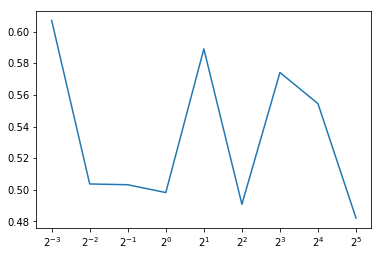

In [15]:
# plot AUC curves
auc_C_avg = np.zeros(len(C_range))
auc_tol_avg = np.zeros(len(tol_range))
for auc, (C, tol) in auc_results.items():
    auc_C_avg[C_range.index(C)] += auc
    auc_tol_avg[tol_range.index(tol)] += auc
auc_C_avg = auc_C_avg / len(tol_range)
auc_tol_avg = auc_tol_avg / len(C_range)

plt.xscale('log', basex = 2)
plt.plot(C_range, auc_C_avg)
plt.show()

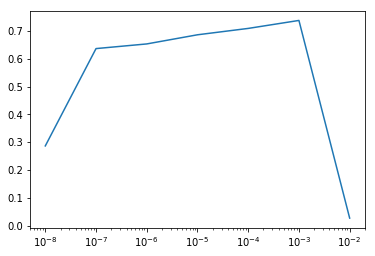

In [16]:
plt.xscale('log', basex = 10)
plt.plot(tol_range, auc_tol_avg)
plt.show()

In [17]:
# fit model and generate outputs
C_opt, tol_opt = opt_setting
lr = lr_model(x_train, y_train_logit, C = C_opt, penalty = penalty, tol = tol_opt)

y_probs_train = lr.predict_proba(x_train)
y_probs_val = lr.predict_proba(x_val)
print y_probs_val[:5]

[[0.77838405 0.22161595]
 [0.81965024 0.18034976]
 [0.72358751 0.27641249]
 [0.58838328 0.41161672]
 [0.78968737 0.21031263]]


In [18]:
# calculate some statistics
y_preds_val = y_probs_val[:,1] > 0.2
print y_preds_val[:5].reshape(5,1)
print "\n", "validation accuracy", np.sum(y_preds_val == y_val_logit, dtype=float) / m_val
print "false positive rate",  np.sum((y_val_logit == 0) * (y_preds_val == 1)) / (np.sum(y_val_logit == 0, dtype=float) + eps)
print "true positive rate", np.sum((y_val_logit == 1) * (y_preds_val == 1)) / (np.sum(y_val_logit == 1, dtype=float) + eps)

[[ True]
 [False]
 [ True]
 [ True]
 [ True]]

validation accuracy 0.598978288633461
false positive rate 0.4430660168355271
true positive rate 0.7952430196401733


In [19]:
# generate ROC curve
train_fprs, train_tprs, val_fprs, val_tprs  = [], [], [], []
for threshold in np.arange(step_size,1,step_size):
    y_preds_val = y_probs_val[:,1] > threshold
    val_fprs.append(np.sum((y_val_logit == 0) * (y_preds_val == 1)) / (np.sum(y_val_logit == 0) + eps))
    val_tprs.append(np.sum((y_val_logit == 1) * (y_preds_val == 1)) / (np.sum(y_val_logit == 1) + eps))
    
    y_preds_train = y_probs_train[:,1] > threshold
    train_fprs.append(np.sum((y_train_logit == 0) * (y_preds_train == 1)) / (np.sum(y_train_logit == 0) + eps))
    train_tprs.append(np.sum((y_train_logit == 1) * (y_preds_train == 1)) / (np.sum(y_train_logit == 1) + eps))
print val_fprs[:5]
print val_tprs[:5]

[0.9999999999977847, 0.9999999999977847, 0.9999999999977847, 0.9999999999977847, 0.9999999999977847]
[0.9999999999896587, 0.9999999999896587, 0.9999999999896587, 0.9999999999896587, 0.9999999999896587]


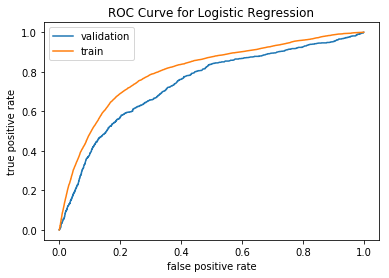

In [20]:
# plot ROC curve
plt.title("ROC Curve for Logistic Regression")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")

valplt, = plt.plot(val_fprs,val_tprs,label='validation')
trainplt, = plt.plot(train_fprs,train_tprs,label='train')
plt.legend(handles = [valplt, trainplt])

plt.show()

In [21]:
auc = 0
x_prev = 0
for x, y in zip(sorted(val_fprs), sorted(val_tprs)):
    auc += (x - x_prev)*y
    x_prev = x
print auc

0.7375028579269144


In [22]:
# save ROC curve
with open("logistic_roc.csv", "w") as file:
    file.write("threshold,fpr,tpr\n")
    for i, (fpr, tpr) in enumerate(zip(val_fprs, val_tprs), 1):
        file.write(str(step_size + i) + "," + str(fpr) + "," + str(tpr) + "\n")
print "done"

done


In [23]:
# find best threshold
senses = np.array(val_tprs, dtype=float) + eps
specs = 1 - np.array(val_fprs, dtype=float) + eps
h_mean = 2. / (1 / senses + 1 / specs)
opt_index = np.argmax(h_mean)
opt_threshold = opt_index*step_size

print "best threshold: " , opt_threshold
print "highest sensitivity: ", val_tprs[opt_index]
print "highest specificity: ", 1 - val_fprs[opt_index]

best threshold:  0.21630000000000002
highest sensitivity:  0.7187176835499616
highest specificity:  0.6453256535231606


In [24]:
# make predictions
y_probs_train = lr.predict_proba(x_train)[:,1]
y_preds_train = y_probs_train > opt_threshold

y_probs_test = lr.predict_proba(x_test)[:,1]
y_preds_test = y_probs_test > opt_threshold

print y_probs_test[:5]
print y_preds_test[:5]

[0.15793883 0.20011545 0.18450602 0.15289383 0.37656103]
[False False False False  True]


In [25]:
# fit on training data to see if there is underfitting
print 'Training set'
print 'predicted proportion of defaults: ', np.sum(y_preds_train == 1) / m_train
print 'accuracy: ', np.sum(y_preds_train == y_train_logit) / m_train

# fit on test set to see if there is overfitting
print '\nTest set'
print 'predicted proportion of defaults: ', np.sum(y_preds_test == 1) / m_test
print 'accuracy: ', np.sum(y_preds_test == y_test_logit) / m_test

Training set
predicted proportion of defaults:  0.28850013684882764
accuracy:  0.7763662074628227

Test set
predicted proportion of defaults:  0.4008392629082284
accuracy:  0.6635650428753878


In [26]:
# calculate F1 score
precision = np.sum((y_test_logit == 1) * (y_preds_test == 1)) / (np.sum(y_preds_test == 1) + eps)
recall = np.sum((y_test_logit == 1) * (y_preds_test == 1)) / (np.sum(y_test_logit == 1) + eps)
F1 = 2/(1 / (precision + eps) + 1 / (recall + eps))
print "precision: ", precision, "\trecall:", recall, "\tF1 score:", F1

precision:  0.2831133363664856 	recall: 0.6980920314175298 	F1 score: 0.4028497527187097


In [27]:
# likelihood estimation
def log_likelihood(probs, y):
    return np.sum(np.log(probs[y*1]))

full_ll = log_likelihood(y_probs_train, y_train_logit)

ll_ratio_test = []
for column in x_train.columns:
    x_temp = x_train.copy()
    x_temp[column] = 0
    y_probs_temp = lr.predict_proba(x_temp)
    temp_ll = log_likelihood(y_probs_temp, y_train_logit)
    ll_ratio_test.append((column,2*(full_ll - temp_ll)))

ll_ratio_test = sorted(ll_ratio_test, key=lambda t: (-t[1], t[0]))

for i in range(5):
    print ll_ratio_test[i]
print ""
for i in range(-5,0):
    print ll_ratio_test[i]

('Log_HPI_Norm', 63996.37677013295)
('CPI', 33433.75270941193)
('ThirdPartyDollars_Norm', 21616.11211511772)
('ThirdPartyLender_State_CA', 21203.120957997773)
('BusinessType_CORPORATION', 20971.84349226029)

('2DigitNaics_33', 18899.27004833918)
('CDC_State_CA', 8876.997760112601)
('ProjectState_CA', 8485.015269876167)
('BorrState_CA', 8432.620887877682)
('ApprovalFiscalYear', -15226.258934311103)


In [28]:
# to discuss/redo cells below

In [ ]:
# from sklearn import metrics

# print 'Training set'
# print metrics.classification_report(y_train_logit, y_pred_train)
# print '\nTest set'
# print metrics.classification_report(y_test_logit, y_pred_test)

In [ ]:
# ####### optional ##########
# # if import from sorted data - need to downsample train dataset to be more balanced
# # can call the following function multiple times for decreasing in log term
# # dropping PIF samples with 50% probability

# def drop_half(train):
#     print 'before drop: ', train.shape[0]
#     dropidx = []
#     for idx, val in train['LoanStatus'].iteritems():
#         if val != 'CHGOFF':
#             rand = np.random.rand()
#             if rand < 0.5:
#                 dropidx.append(idx)
#     train = train.drop(dropidx)
#     print 'after drop: ', train.shape[0]
#     return train
    
# train = drop_half(train)
# train = drop_half(train)
# # test = drop_half(test)

# chargeoff_count = (train['LoanStatus'] == "CHGOFF").sum()
# print 'Chargeoffs:', chargeoff_count
# print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(train)

# chargeoff_count = (test['LoanStatus'] == "CHGOFF").sum()
# print 'Chargeoffs:', chargeoff_count
# print 'Percentage of loans that defaulted:', float(chargeoff_count)/len(test)